In [37]:
#google drive'a bağlanma

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import cv2    #open cv
import os

import warnings
warnings.filterwarnings('ignore')

In [10]:

#load data
labels = ["PNEUMONIA","NORMAL"]
img_size = 150  #150*150

def get_traininng_data(data_dir):
  data = []
  for label in labels:  #normal
    path = os.path.join(data_dir,label) #yolu
    class_num = labels.index(label)   #"/content/drive/My Drive/Colab/DL-akcigerKanseri/chest_xray"

    for img in tqdm(os.listdir(path), desc=f"Yükleniyor: {label}"):  # tqdm burada
      try:
        #goruntuyu oku ve işle
        img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE) #AKCİĞER KANSERİ GRİ RENKLİ
        if img_arr is None:
          print("Read image error!")
          continue

        #görüntüuyü yendien boyutlandır
        resized_arr = cv2.resize(img_arr,(img_size,img_size)) #150*150

        #veriyi listeye ekle
        data.append([resized_arr,class_num])

      except Exception as e:
        print("Error",e)

  return np.array(data,dtype=object)


train_data = get_traininng_data("/content/drive/My Drive/Colab/DL-akcigerKanseri/chest_xray/train")
test_data = get_traininng_data("/content/drive/My Drive/Colab/DL-akcigerKanseri/chest_xray/test")
val_data = get_traininng_data("/content/drive/My Drive/Colab/DL-akcigerKanseri/chest_xray/val")
# eğitimde burada train test ve val olarak değişken ismi verilmiş


Yükleniyor: NORMAL: 100%|██████████| 234/234 [00:09<00:00, 24.57it/s]
Yükleniyor: PNEUMONIA: 0it [00:00, ?it/s]
Yükleniyor: NORMAL: 0it [00:00, ?it/s]


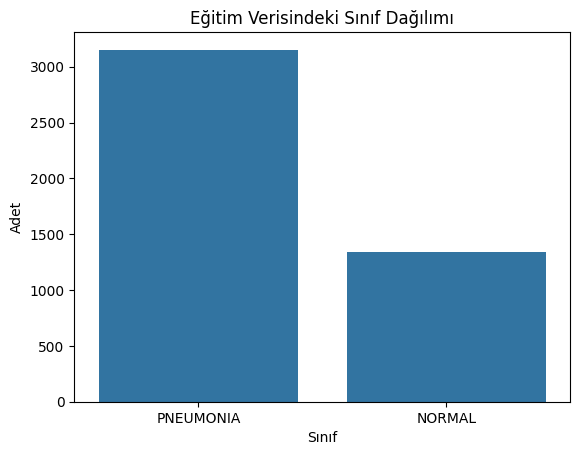

x_train şekli: (4493, 150, 150)
y_train sınıflar: {0, 1}
Bir görüntü örneği:


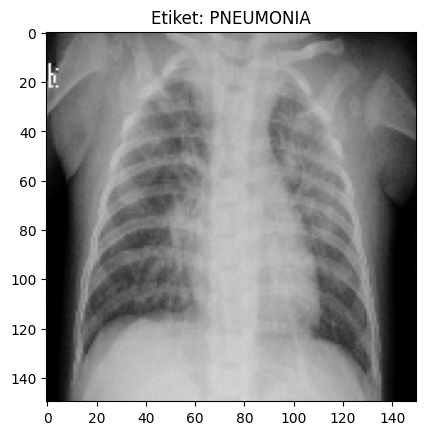

x_train şekli: (4493, 150, 150)
y_train sınıflar: {0, 1}
Bir görüntü örneği:


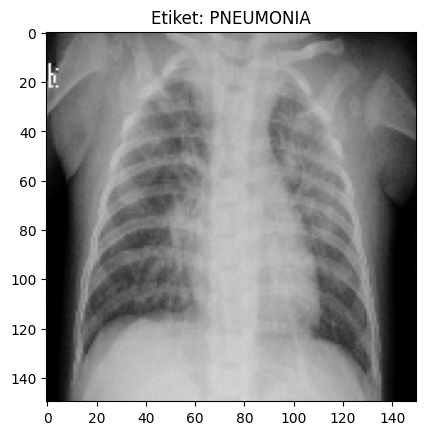

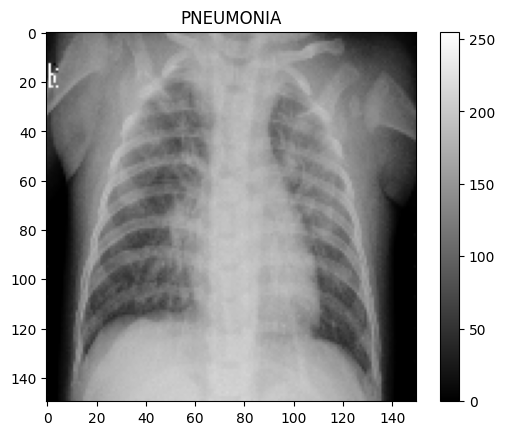

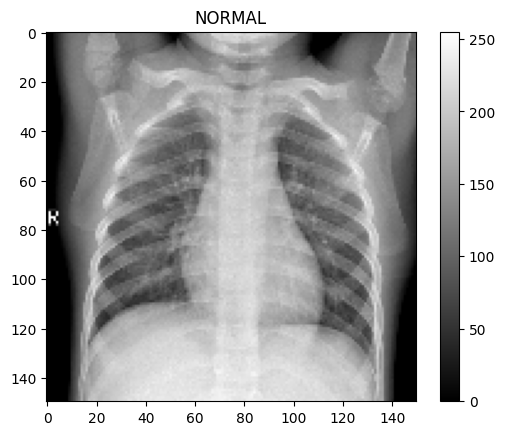

In [15]:
#data visualization and preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

l = []
for i in train_data:
  if(i[1]==0):
    l.append("PNEUMONIA")
  else:
    l.append("NORMAL")

sns.countplot(x=l)
plt.title("Eğitim Verisindeki Sınıf Dağılımı")
plt.xlabel("Sınıf")
plt.ylabel("Adet")
plt.show()


x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []


for feature,label in train_data:
  x_train.append(feature)
  y_train.append(label)

for feature,label in test_data:
  x_test.append(feature)
  y_test.append(label)

for feature,label in val_data:
  x_val.append(feature)
  y_val.append(label)

#Değişkenleri görsel olarak inceleme
print("x_train şekli:", np.array(x_train).shape)
print("y_train sınıflar:", set(y_train))
print("Bir görüntü örneği:")
plt.imshow(x_train[0], cmap='gray')
plt.title("Etiket: " + ("PNEUMONIA" if y_train[0]==0 else "NORMAL"))
plt.show()

# Sayısal dağılımı da görmek
print("x_train şekli:", np.array(x_train).shape)
print("y_train sınıflar:", set(y_train))
print("Bir görüntü örneği:")
plt.imshow(x_train[0], cmap='gray')
plt.title("Etiket: " + ("PNEUMONIA" if y_train[0]==0 else "NORMAL"))
plt.show()



plt.figure()
plt.imshow(train_data[0][0],cmap='gray')
plt.title(labels[train_data[0][1]])
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure()
plt.imshow(train_data[-1][0],cmap='gray')
plt.title(labels[train_data[-1][1]])
plt.colorbar()
plt.grid(False)
plt.show()



In [16]:
#normalization:[0,1]
# [0,255]/255 = [0,1]


x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255

#(5216,150,150) -> (5216,150,150,1)
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [23]:
#data augmentation

datagen = ImageDataGenerator(
    featurewise_center = False,   #verisetinin genel ortalamsını 0 yapar
    samplewise_center = False,    #her bir örneğin ortalamsını 0 yapar
    featurewise_std_normalization = False,   #veriyi verinin standartına bölme
    samplewise_std_normalization = False,    #her bir örneği kendi standart sapmasına bölme işlemi
    zca_whitening = False,   #zca beyazlatma yöntemi,korelasyon azaltma
    rotation_range = 30,   #resimleri x derece rastgele döndür
    zoom_range = 0.2,   #rastgele yakınlaştrıma işlemi
    width_shift_range = 0.1,  #yatay olarak rastgele kaydırma
    height_shift_range =0.1, #resimleri dikey olarak rastgele kaydirma
    horizontal_flip = True,  # resimleri rastgele yatay olarak çevirir
    vertical_flip = False  # resimleri rastgele dikey olarak çevirir

)

datagen.fit(x_train)



In [ ]:
# create deep learning model and train


**Feature Extraction Blok:**

*   (con2d - Normalizasyon - MaxPooling)
*   (con2d - Dropout- Normalizasyon - MaxPooling)


*   (con2d - Normalizasyon - MaxPooling)

*   (con2d - Dropout - Normalizasyon - MaxPooling)
*   (con2d - Dropout - Normalizasyon - MaxPooling)

**Classification Blok:**


*   flatten - Densee -Dropout - Dense (output)

**Compiler:**


*   optimizer (rmsprop)

*   Loss (binary cross ent.)
*   metric (accuracy)










In [28]:
model = Sequential()
model.add(Conv2D(128, (3, 3),strides=1,padding="same", activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),strides=2,padding="same"))

model.add(Conv2D(64, (3, 3),strides=1,padding="same", activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),strides=2,padding="same"))

model.add(Conv2D(32, (3, 3),strides=1,padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),strides=2,padding="same"))

model.add(Conv2D(128, (3, 3),strides=1,padding="same", activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),strides=2,padding="same"))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))   #%20'sini kapatacak
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 150, 150, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 150, 150, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 75, 75, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 38, 38, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 38, 38, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 19, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 19, 19, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,770,593 (6.75 MB)

 Trainable params: 1,769,889 (6.75 MB)

 Non-trainable params: 704 (2.75 KB)

In [30]:
#learning

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
epoch_number=3
model.fit(datagen.flow(x_train,y_train, batch_size=32),
                    epochs=epoch_number,
                    validation_data=datagen.flow(x_test,y_test),
                    callbacks=[learning_rate_reduction])
print("Loss of Model: ",model.evaluate(x_test,y_test)[0])
print("Accuracy of Model: ",model.evaluate(x_test,y_test)[1]*100)


Epoch 1/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 932s 7s/step - accuracy: 0.7678 - loss: 1.3343 - val_accuracy: 0.6250 - val_loss: 10.0809 - learning_rate: 0.0010
Epoch 2/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 931s 7s/step - accuracy: 0.8550 - loss: 0.3786 - val_accuracy: 0.6250 - val_loss: 19.5873 - learning_rate: 0.0010
Epoch 3/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9043 - loss: 0.2669
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
141/141 ━━━━━━━━━━━━━━━━━━━━ 944s 7s/step - accuracy: 0.9042 - loss: 0.2669 - val_accuracy: 0.6250 - val_loss: 25.3796 - learning_rate: 0.0010
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8889 - loss: 6.0116
Loss of Model:  20.112197875976562
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8889 - loss: 6.0116
Accuracy of Model:  62.5


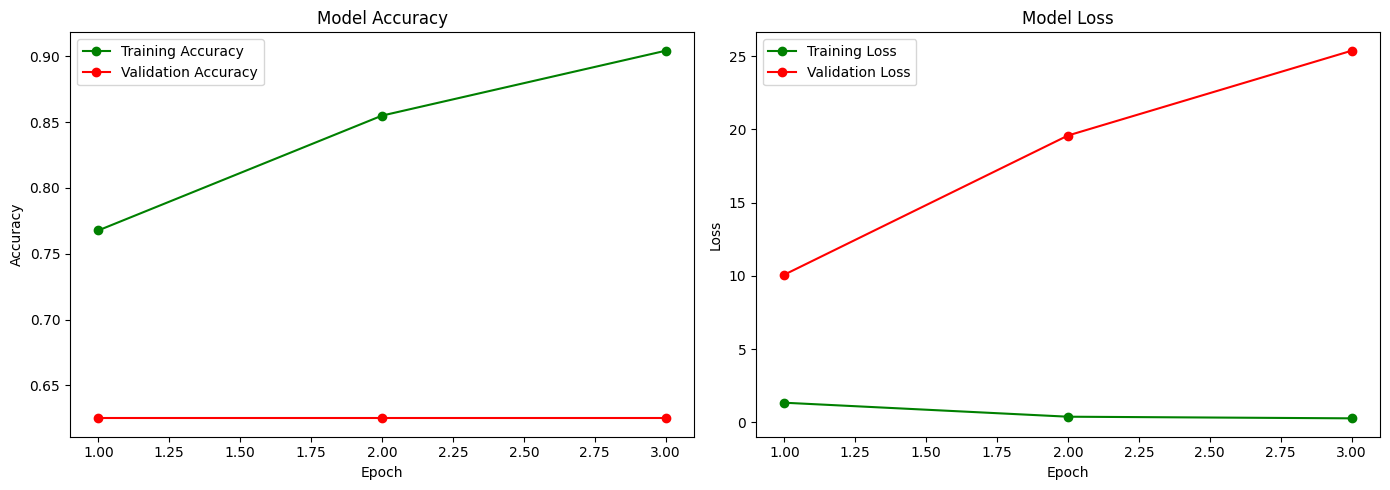

In [33]:
#EVALUATİON

#EPOCH SONUÇLARI
epochs = [1, 2, 3]
train_acc = [0.7678, 0.8550, 0.9043]
val_acc = [0.6250, 0.6250, 0.6250]
train_loss = [1.3343, 0.3786, 0.2669]
val_loss = [10.0809, 19.5873, 25.3796]

# Grafik
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss
ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [41]:
#model save
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.models import load_model
model.save('/content/drive/My Drive/Colab/DL-akcigerKanseri/DL-akcigerKanseri.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
